# Part 1: Stitching pairs of images

In [6]:
# imports

import numpy as np
import skimage
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import color, io, transform
import scipy
import cv2
import random

In [7]:
# Provided code - nothing to change here

"""
Harris Corner Detector
Usage: Call the function harris(filename) for corner detection
Reference   (Code adapted from):
             http://www.kaij.org/blog/?p=89
             Kai Jiang - Harris Corner Detector in Python
             
"""
from pylab import *
from scipy import signal
from scipy import *
import numpy as np
from PIL import Image

def harris(filename, min_distance = 10, threshold = 0.1):
    """
    filename: Path of image file
    threshold: (optional)Threshold for corner detection
    min_distance : (optional)Minimum number of pixels separating 
     corners and image boundary
    """
    im = np.array(Image.open(filename).convert("L"))
    harrisim = compute_harris_response(im)
    filtered_coords = get_harris_points(harrisim,min_distance, threshold)
    plot_harris_points(im, filtered_coords)

def gauss_derivative_kernels(size, sizey=None):
    """ returns x and y derivatives of a 2D 
        gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    y, x = mgrid[-size:size+1, -sizey:sizey+1]
    #x and y derivatives of a 2D gaussian with standard dev half of size
    # (ignore scale factor)
    gx = - x * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    gy = - y * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    return gx,gy

def gauss_kernel(size, sizey = None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = mgrid[-size:size+1, -sizey:sizey+1]
    g = exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

def compute_harris_response(im):
    """ compute the Harris corner detector response function 
        for each pixel in the image"""
    #derivatives
    gx,gy = gauss_derivative_kernels(3)
    imx = signal.convolve(im,gx, mode='same')
    imy = signal.convolve(im,gy, mode='same')
    #kernel for blurring
    gauss = gauss_kernel(3)
    #compute components of the structure tensor
    Wxx = signal.convolve(imx*imx,gauss, mode='same')
    Wxy = signal.convolve(imx*imy,gauss, mode='same')
    Wyy = signal.convolve(imy*imy,gauss, mode='same')   
    #determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy   
    return Wdet / Wtr

def get_harris_points(harrisim, min_distance=10, threshold=0.1):
    """ return corners from a Harris response image
        min_distance is the minimum nbr of pixels separating 
        corners and image boundary"""
    #find top corner candidates above a threshold
    corner_threshold = max(harrisim.ravel()) * threshold
    harrisim_t = (harrisim > corner_threshold) * 1    
    #get coordinates of candidates
    candidates = harrisim_t.nonzero()
    coords = [ (candidates[0][c],candidates[1][c]) for c in range(len(candidates[0]))]
    #...and their values
    candidate_values = [harrisim[c[0]][c[1]] for c in coords]    
    #sort candidates
    index = argsort(candidate_values)   
    #store allowed point locations in array
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1   
    #select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i][0]][coords[i][1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i][0]-min_distance):(coords[i][0]+min_distance),
                (coords[i][1]-min_distance):(coords[i][1]+min_distance)] = 0               
    return filtered_coords

def plot_harris_points(image, filtered_coords):
    """ plots corners found in image"""
    figure()
    gray()
    imshow(image)
    plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'r*')
    axis('off')
    show()

# Usage: 
#harris('./path/to/image.jpg')

In [8]:
# Provided code - nothing to change here

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)

In [9]:
def readimg(imgname):
    img = cv2.imread(imgname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def readimg_color(imgname):
    img = cv2.imread(imgname)
    img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return img

In [13]:
def sift_descriptor(image):
    print("Initializing SIFT and finding keypoints and descriptors")
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, des = sift.detectAndCompute(image, None)

    return keypoints, des

def show_sift(keypoints, image):
    output = image.copy()
    output = cv2.drawKeypoints(image, keypoints, output)
    plt.imshow(outputs)
    plt.show()

def calculate_distance(kp_l, kp_r, des_l, des_r, num_threshold):
    print("Finding Euclidean distance between descriptors")
    distance = scipy.spatial.distance.cdist(des_l, des_r, 'sqeuclidean')

    # print(np.where(distance < num_threshold))
    index_1 = np.where(distance < num_threshold)[0]
    index_2 = np.where(distance < num_threshold)[1]

    coord1 = np.array([kp_l[idx].pt for idx in index_1])
    coord2 = np.array([kp_r[idx].pt for idx in index_2])

    coordinate_pairs = np.concatenate((coord1, coord2), axis=1)

    return coordinate_pairs

def get_errors(matches, H):
    num_pairs = len(matches)

    p1 = np.concatenate((matches[:, 0:2], np.ones((1, num_pairs)).T), axis=1)
    # print(p1)
    p2 = matches[:, 2:4]

    transform_p1 = np.zeros((num_pairs, 2))

    for i in range(num_pairs):
        transform_p1[i] = (np.matmul(H, p1[i]) / np.matmul(H, p1[i])[-1])[0:2]

    errors = np.square(np.linalg.norm(p2 - transform_p1, axis=1))

    return errors


In [14]:
import random

def compute_H(subset):
    A = []
    # print(subset.shape)

    for i in range(subset.shape[0]):
        p1 = np.append(subset[i][0:2], 1)
        p2 = np.append(subset[i][2:4], 1)
        
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        A.append(row1)
        A.append(row2)

    A = np.array(A)

    U, s, V = np.linalg.svd(A)
    H = V[len(V)-1].reshape(3, 3)
    H = H / H[2, 2]

    return H

def show_inlier_matches(img_l, img_r, inliers):
    print("num of inliers shown in the matching: " + str(len(inliers)))
    h_l, w_l = img_l.shape
    h_r, w_r = img_r.shape

    vis = np.zeros((max(h_l, h_r), w_l + w_r), np.uint8)
    vis[:, :w_l] = img_l
    vis[:h_r, w_l:] = img_r

    fig, ax = plt.subplots()
    ax.imshow(vis)
    ax.plot([inliers[:,0], inliers[:,2] + w_r],[inliers[:,1], inliers[:,3]])
    plt.show()

def ransac(img_l, img_r, matches, thres_ransac):
    itertimes = 1000
    inliners = 0
    max_inliners = 0

    for iter in range(itertimes):
        subset_idx = random.sample(range(matches.shape[0]), k=4)
        subset = matches[subset_idx]

        H = compute_H(subset)
        #check if H is full rank
        if np.linalg.matrix_rank(H) < 3:
            continue

        errors = get_errors(matches, H)
        idx = np.where(errors < thres_ransac)[0]
        inlinerspts = matches[idx]

        inliners = len(inlinerspts)
        if inliners >= max_inliners:
            which_inliners = inlinerspts.copy()
            max_inliners = inliners
            best_H = H.copy()
            
            avg_residual = sum(get_errors(matches[idx], H)) / inliners

    print("num of inliners: " + str(max_inliners) + " average residual: " + str(avg_residual))
    show_inlier_matches(img_l, img_r, which_inliners)
    return best_H

In [15]:
# I took help from various internet sources to understand how to use these warping functions and some parts of the code are adapted from the sources I used
def warp_images(image0, image1, H):
    transform = skimage.transform.ProjectiveTransform(H)
    warp = skimage.transform.warp

    r, c = image1.shape[:2]
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    warped_corners = transform(corners)

    all_corners = np.vstack((warped_corners, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1])

    offset = skimage.transform.SimilarityTransform(translation=-corner_min)

    image0_ = warp(image0, offset.inverse, output_shape=output_shape, cval=-1)

    image1_ = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=-1)

    image0_zeros = warp(image0, offset.inverse, output_shape=output_shape, cval=0)

    image1_zeros = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=0)

    overlap = (image0_ != -1.0 ).astype(int) + (image1_ != -1.0).astype(int)
    overlap += (overlap < 1).astype(int)
    merged = (image0_zeros+image1_zeros)/overlap

    im = Image.fromarray((255*merged).astype('uint8'), mode='RGB')
    im = np.asarray(im)

    return im


In [16]:
def stitch_2pic():
    leftimg_bw = readimg('left.jpg')
    rightimg_bw = readimg('right.jpg')
    leftimg_c = readimg_color('left.jpg')
    rightimg_c = readimg_color('right.jpg')

    thres = 7000
    thres_ransac = 0.5

    kp_l, des_l = sift_descriptor(leftimg_bw)
    kp_r, des_r = sift_descriptor(rightimg_bw)

    matches = calculate_distance(kp_l, kp_r, des_l, des_r, thres)
    H_matrix = ransac(leftimg_bw, rightimg_bw, matches, thres_ransac)
    stitched_img = warp_images(rightimg_c, leftimg_c, H_matrix)

    plt.imshow(stitched_img)
    plt.show()

Initializing SIFT and finding keypoints and descriptors
Initializing SIFT and finding keypoints and descriptors
Finding Euclidean distance between descriptors


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead


num of inliners: 10 average residual: 0.19282993534113335
num of inliers shown in the matching: 10


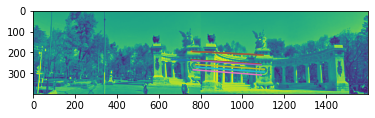

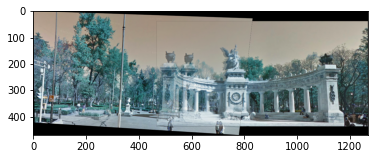

In [19]:
stitch_2pic()